# Simulation 4 - Additive

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV, KFold

import torch
from torch.utils.data import Dataset,DataLoader
from torch import optim
import torch.nn as nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F

## Random Feature

In [2]:
def sample_1d(pdf, gamma):
    if pdf=='G':
        w=torch.randn(1)*gamma
        return w
    elif pdf=='L':
        w=torch.distributions.laplace.Laplace(torch.tensor([0.0]), torch.tensor([1.0])).sample()*gamma
        return w
    elif pdf=='C':
        w=torch.distributions.cauchy.Cauchy(torch.tensor([0.0]), torch.tensor([1.0])).sample()*gamma
        return w
    
def sample(pdf, gamma, d):
    return torch.tensor([sample_1d(pdf, gamma) for _ in range(d)])

class RandomFourierFeature:
    """Random Fourier Feature
    Parameters
    ----------
    d : int
        Input space dimension
    D : int
        Feature space dimension
    W : shape (D,d)
    b : shape (D)
    kernel : char
        Kernel to use; 'G', 'L', or 'C'
    gamma : float
        pdf parameter
    """

    def __init__(self, d, D, W=None, b=None, kernel='G', gamma=1):

        self.d = d
        self.D = D
        self.gamma = gamma

        kernel = kernel.upper()
        if kernel not in ['G', 'L', 'C']:
            raise Exception('Invalid Kernel')
        self.kernel = kernel

        if W is None or b is None:
            self.create()
        else:
            self.__load(W, b)

    def __load(self, W, b):
        """Load from existing Arrays"""

        self.W = W.reshape([self.D, self.d])
        self.b = b
    

    def create(self):
        """Create a d->D fourier random feature"""

        self.b = torch.rand(self.D)*2*torch.pi
        self.W = sample(self.kernel, self.gamma, self.d*self.D).reshape(self.D,self.d)

    def transform(self, x):
        """Transform a vector using this feature
        Parameters
        ----------
        x : (shape=(n,d))
            to transform; must be single dimension vector
        Returns
        -------
        x : (shape=(n,D))
            Feature space transformation of x
        """
       
        result=torch.sqrt(torch.tensor([2.0/self.D])) * torch.cos( self.W @ x.T  + (self.b.reshape(-1,1) @ torch.ones(len(x)).reshape(1,-1))) 
        return result.T

data generation

In [3]:
n=2000
p=32
np.random.seed(0)
dataW=np.random.uniform(0,1, (n,p)) #n points
np.random.seed(1)
dataU=np.random.uniform(0,1, (n,1))
dataU_copy=np.tile(dataU, p)
data=(dataW+0.3*dataU_copy)/1.3
np.random.seed(2)
noise=np.random.normal(0,1,n)

# function
def f1(x):
    return 6*(0.1*np.sin(2*np.pi*x)+0.2*np.cos(2*np.pi*x)+0.3*np.sin(2*np.pi*x)**2
              +0.4*np.cos(2*np.pi*x)**3+0.5*np.sin(2*np.pi*x)**3)
def f2(x):
    return 3*(2*x-1)**2
def f3(x):
    return 5*x
def f4(x):
    return (4*np.sin(2*np.pi*x))/(2-np.sin(2*np.pi*x))

y=f1(data[:,0])+f2(data[:,1])+f3(data[:,2])+f4(data[:,3])+noise


np.random.seed(3)
dataW=np.random.uniform(0,1, (n,p)) #n points
np.random.seed(4)
dataU=np.random.uniform(0,1, (n,1))
dataU_copy=np.tile(dataU, p)
calibration_x=(dataW+0.3*dataU_copy)/1.3
np.random.seed(5)
calibration_noise=np.random.normal(0,1,n)
calibration_y=f1(calibration_x[:,0])+f2(calibration_x[:,1])+f3(calibration_x[:,2])+f4(calibration_x[:,3])+calibration_noise



np.random.seed(6)
dataW=np.random.uniform(0,1, (2*n,p)) #n points
np.random.seed(7)
dataU=np.random.uniform(0,1, (2*n,1))
dataU_copy=np.tile(dataU, p)
test_x=(dataW+0.3*dataU_copy)/1.3
np.random.seed(8)
test_noise=np.random.normal(0,1,2*n)
test_y=f1(test_x[:,0])+f2(test_x[:,1])+f3(test_x[:,2])+f4(test_x[:,3])+test_noise

In [4]:
train_x=data
train_y=y

total_x=np.vstack((train_x,calibration_x))
total_y=np.hstack((train_y,calibration_y))

nntrain_x = torch.from_numpy(train_x).float()
nntrain_y = torch.squeeze(torch.from_numpy(train_y).float()) 
nntest_x= torch.from_numpy(test_x).float()
nntest_y = torch.squeeze(torch.from_numpy(test_y).float())

class mydataset(Dataset):
    def __init__(self, x, y):
        self._x = x
        self._y = y
        self._len = len(x)

    def __getitem__(self, item): 
        return self._x[item], self._y[item]

    def __len__(self):
        return self._len

## KRR

In [5]:
t0=time.time()
krr = KernelRidge(kernel='rbf',gamma=1/2)
param_grid = {
    'alpha': [1e-4,1e-3,1e-2,1e-1,1]
}

kf = KFold(n_splits=5, shuffle=True)  
grid_search = GridSearchCV(krr, param_grid, cv=kf)
grid_search.fit(total_x, total_y)

print("Best parameters found: ", grid_search.best_params_)

best_krr = grid_search.best_estimator_
krr_pred = best_krr.predict(test_x)

t1=time.time()-t0
print(mean_squared_error(test_y,krr_pred))
print("Time:",t1)

Best parameters found:  {'alpha': 0.1}
5.118666164092953
Time: 12.83199954032898


## RF

In [47]:
t0=time.time()
model=Ridge()
param_grid = {
    'alpha': [1e-4,1e-3,1e-2,1e-1,1]
}
rff=RandomFourierFeature(p,500,kernel='G',gamma=1)
total_feature=rff.transform(total_x)
test_feature=rff.transform(test_x)

kf = KFold(n_splits=5, shuffle=True)  
grid_search = GridSearchCV(model, param_grid, cv=kf)
grid_search.fit(total_feature, total_y)

print("Best parameters found: ", grid_search.best_params_)

best_model = grid_search.best_estimator_
rf_pred = best_model.predict(test_feature)

t1=time.time()-t0
print(mean_squared_error(test_y,rf_pred))
print("Time:",t1)

Best parameters found:  {'alpha': 1}
8.384348139005139
Time: 1.6626148223876953


# MLKM

In [48]:
rff1=RandomFourierFeature(p,256,kernel='G',gamma=1)
rff2=RandomFourierFeature(16,16,kernel='G',gamma=1)

class KernelNet(nn.Module): 
    def __init__(self):
        super(KernelNet, self).__init__()
        self.fc1 = nn.Linear(256, 16)
        self.fc2 = nn.Linear(16, 1)
        
    def forward(self, x):
        x = rff1.transform(x)
        x=self.fc1(x)
        x = rff2.transform(x)
        return self.fc2(x)

#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=-0.1,b=0.1)
        m.bias.data.fill_(0.01)


def MultiLayerKfold(kfold,param_grid):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    param_error=[]
    for param in param_grid:
        k_error=[]
        for k in range(kfold):
            Kfold_val_x, Kfold_val_y=nntrain_x[int(n/5)*k:int(n/5)*(k+1)], nntrain_y[int(n/5)*k:int(n/5)*(k+1)]
            Kfold_train_x = torch.cat((nntrain_x[:int(n/5)*k],nntrain_x[int(n/5)*(k+1):]),dim = 0)
            Kfold_train_y = torch.cat((nntrain_y[:int(n/5)*k],nntrain_y[int(n/5)*(k+1):]),dim = 0)
           
            net = KernelNet()  #### KernelNet!
            net = net.to(device)
            torch.manual_seed(1)
            net.apply(init_weights)
            criterion=nn.MSELoss() 
            optimizer=optim.SGD(net.parameters(),lr=1e-3,momentum=0.9,weight_decay=param) #optim.Adam(...)
            kfoldtrain_loader = DataLoader(mydataset(Kfold_train_x, Kfold_train_y),batch_size=128, shuffle=True)
            
            for epoch in range(2000): 
                for x, y in kfoldtrain_loader: #for batch, (x, y) in enumerate(train_loader): 
                    x, y = x.to(device), y.to(device)
                    # Compute prediction error
                    y_pred = net(x)
                    y_pred = torch.squeeze(y_pred)
                    train_loss = criterion(y_pred, y)
                    # Backpropagation
                    optimizer.zero_grad() 
                    train_loss.backward()
                    optimizer.step()
            
            x0=Kfold_val_x[:].float()
            with torch.no_grad():
                x0 = x0.to(device)
                val_pred = net(x0)
            
            k_error.append(mean_squared_error(val_pred,Kfold_val_y))
        
        param_error.append(np.mean(k_error))
        
    print(param_error) 
    return param_grid[np.argmin(param_error)]  

bestweight=MultiLayerKfold(5,[1e-4,1e-3,1e-2,1e-1,1])     
print(bestweight)

[14.902661, 13.967783, 10.633852, 7.1439323, 14.737204]
0.1


In [58]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=128, shuffle=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = KernelNet()
net = net.to(device)
torch.manual_seed(1)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=1e-3,momentum=0.9,weight_decay=bestweight) #optim.Adam(...)

loss=[]
kernelnn_trainloss=[]
kernelnn_testloss=[]
t0 = time.time()
for epoch in range(2000): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        loss.append(train_loss)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    
    x0=torch.from_numpy(train_x[:]).float()
    with torch.no_grad():
        x0 = x0.to(device)
        train_pred = net(x0)
    
    x0=torch.from_numpy(test_x[:]).float()
    with torch.no_grad():
        x0 = x0.to(device)
        test_pred = net(x0)
    
    kernelnn_trainloss.append(mean_squared_error(train_pred,train_y))
    kernelnn_testloss.append(mean_squared_error(test_pred,test_y))
    
    if epoch % 100 == 0:        
        print(f'''epoch {epoch}
            Train set - loss: {kernelnn_trainloss[-1]}
            Test set - loss: {kernelnn_testloss[-1]}
            ''')
        
    
dnn_fit = time.time() - t0
print("KernelNet complexity and model fitted in %.3f s" % dnn_fit)

KernelNet(
  (fc1): Linear(in_features=256, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 23.075340395084677
            Test set - loss: 23.68832544516772
            
epoch 100
            Train set - loss: 6.0114440134198555
            Test set - loss: 7.327900470058232
            
epoch 200
            Train set - loss: 5.294454087539094
            Test set - loss: 6.984332324553461
            
epoch 300
            Train set - loss: 5.258074237705841
            Test set - loss: 6.987568579928947
            
epoch 400
            Train set - loss: 5.205758382890296
            Test set - loss: 6.973770692527085
            
epoch 500
            Train set - loss: 5.146826648678252
            Test set - loss: 6.970283392145362
            
epoch 600
            Train set - loss: 5.122845714261476
            Test set - loss: 6.984259239026678
            
epoch 700
            Train set - loss: 5

KernelNet(
  (fc1): Linear(in_features=256, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 24.125129747258644
            Test set - loss: 24.773457577710555
            
epoch 100
            Train set - loss: 4.7653136374328655
            Test set - loss: 6.897144073933321
            
epoch 200
            Train set - loss: 3.3763637574226526
            Test set - loss: 7.514193970899638
            
epoch 300
            Train set - loss: 2.3122727436596247
            Test set - loss: 8.57720159958374
            
epoch 400
            Train set - loss: 1.5827245537213501
            Test set - loss: 9.626272464834024
            
epoch 500
            Train set - loss: 1.112178910537011
            Test set - loss: 10.588998750755504
            
epoch 600
            Train set - loss: 0.7951511723901783
            Test set - loss: 11.339026105715512
            
epoch 700
            Train set - l

100%|██████████| 2000/2000 [00:00<00:00, 3982.83it/s]


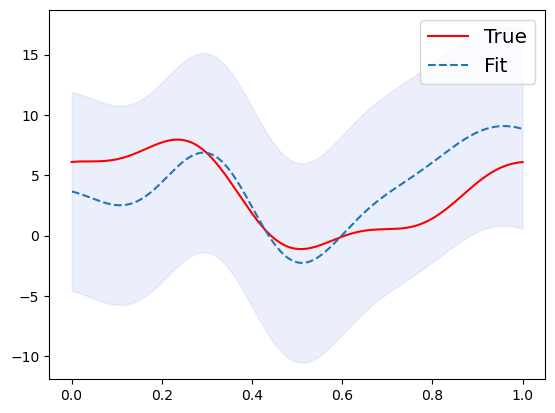

In [17]:
### test

rff1=RandomFourierFeature(p,256,kernel='G',gamma=1)
rff2=RandomFourierFeature(16,16,kernel='G',gamma=1)
bestweight=0.001

class KernelNet(nn.Module): 
    def __init__(self):
        super(KernelNet, self).__init__()
        self.fc1 = nn.Linear(256, 16)
        self.fc2 = nn.Linear(16, 1)
        
    def forward(self, x):
        x = rff1.transform(x)
        x=self.fc1(x)
        x = rff2.transform(x)
        return self.fc2(x)

#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=-0.1,b=0.1)
        m.bias.data.fill_(0.01)
        
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=128, shuffle=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = KernelNet()
net = net.to(device)
torch.manual_seed(1)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=1e-3,momentum=0.9,weight_decay=bestweight) #optim.Adam(...)

loss=[]
kernelnn_trainloss=[]
kernelnn_testloss=[]
t0 = time.time()
for epoch in range(2000): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        loss.append(train_loss)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    
    x0=torch.from_numpy(train_x[:]).float()
    with torch.no_grad():
        x0 = x0.to(device)
        train_pred = net(x0)
    
    x0=torch.from_numpy(test_x[:]).float()
    with torch.no_grad():
        x0 = x0.to(device)
        test_pred = net(x0)
    
    kernelnn_trainloss.append(mean_squared_error(train_pred,train_y))
    kernelnn_testloss.append(mean_squared_error(test_pred,test_y))
    
    if epoch % 100 == 0:        
        print(f'''epoch {epoch}
            Train set - loss: {kernelnn_trainloss[-1]}
            Test set - loss: {kernelnn_testloss[-1]}
            ''')
        
    
dnn_fit = time.time() - t0
print("KernelNet complexity and model fitted in %.3f s" % dnn_fit)


##conformal prediction comparison
#predict
x0=torch.from_numpy(calibration_x[:]).float()
with torch.no_grad():
    x0 = x0.to(device)
    pred = net(x0)
    score=np.abs(pred.reshape(-1)-calibration_y[:])
sorted_score, sorted_indices=torch.sort(score)
q=(len(calibration_x)+1)*0.95
print(np.ceil(q))
a=sorted_score[int(np.ceil(q))]

coverage=0
x0=torch.from_numpy(test_x[:]).float()
with torch.no_grad():
    x0 = x0.to(device)
    pred = net(x0)
for i in range(len(test_x)):
    if pred.detach().numpy()[i][0]-a<test_y[i] and pred.detach().numpy()[i][0]+a>test_y[i]:
        coverage=coverage+1
coverage=coverage/len(test_x)

print("length",2*a)
print("95 coverage",coverage)



np.random.seed(2)
plot_x=np.random.uniform(0,1, (n,p)) #n points
plot_x[:,1:]=1/2
np.random.seed(3)
plot_noise=np.random.normal(0,1,n)
plot_y=f1(plot_x[:,0])+f2(plot_x[:,1])+f3(plot_x[:,2])+f4(plot_x[:,3])+plot_noise

pred_xall=[]
pred_yall=[]
true_yall=[]
dist=[]
mark=0
length=[]
for i in tqdm(range(len(plot_x))):
    x0=torch.from_numpy(plot_x[i:i+1]).float()
    x0 = x0.to(device)
    pred = net(x0)
    
    mark=mark+1
    dd=a
    length.append(2*dd)
    
    #coverage
    if pred.detach().numpy()[0][0]-dd<plot_y[i] and pred.detach().numpy()[0][0]+dd>plot_y[i]:
        coverage=coverage+1
    pred_xall.append(plot_x[i][0])
    pred_yall.append(pred.detach().numpy()[0][0])
    true_yall.append(plot_y[i])
    dist.append(dd)
    
band=np.array([pred_xall,pred_yall,list(map(lambda x,y:x-y, pred_yall,dist)),list(map(lambda x,y:x+y, pred_yall,dist))]).T
sort_band=band[np.argsort(band[:,0])]
plx=np.linspace(0,1,1000)
ply=f1(plx)+f2(1/2)+f3(1/2)+f4(1/2)
plt.plot(plx,ply,color='red')
plt.plot(sort_band.T[0],sort_band.T[1],linestyle='dashed')
plt.fill_between(sort_band.T[0],sort_band.T[2],sort_band.T[3],alpha=0.1,color='royalblue')
plt.legend(['True','Fit'],fontsize="x-large")
plt.show()

In [59]:
kernel_x0=torch.from_numpy(test_x[:]).float()
with torch.no_grad():
    kernel_x0 = kernel_x0.to(device)
    kernel_pred = net(kernel_x0)

## RK

In [51]:
rff0=RandomFourierFeature(p,256,kernel='G',gamma=1)
rff1=RandomFourierFeature(16,16,kernel='G',gamma=1)

class ResidualBlock(nn.Module):
    def __init__(self,infeatures,outfeatures,rff):
        super(ResidualBlock,self).__init__()
        self.infeatures = infeatures
        self.outfeatures = outfeatures
        self.rff=rff
        
        self.fc1 = nn.Linear(infeatures,outfeatures)
        self.fc2 = nn.Linear(outfeatures,outfeatures)
    
    def forward(self, x):
        rff=self.rff
        x = self.fc1(x)
        y = rff.transform(x)
        y = self.fc2(y)
        return x+y

class ResKernelNet(nn.Module): 
    def __init__(self):
        super(ResKernelNet, self).__init__()
        self.rblock1 = ResidualBlock(256,16,rff1)
        self.fc2 =nn.Linear(16,1)
 
    def forward(self, x):
        x = rff0.transform(x)
        x = self.rblock1(x)
        return self.fc2(x)

#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=-0.1,b=0.1)
        m.bias.data.fill_(0.01)

def MultiLayerKfold(kfold,param_grid):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    param_error=[]
    for param in param_grid:
        k_error=[]
        for k in range(kfold):
            Kfold_val_x, Kfold_val_y=nntrain_x[int(n/5)*k:int(n/5)*(k+1)], nntrain_y[int(n/5)*k:int(n/5)*(k+1)]
            Kfold_train_x = torch.cat((nntrain_x[:int(n/5)*k],nntrain_x[int(n/5)*(k+1):]),dim = 0)
            Kfold_train_y = torch.cat((nntrain_y[:int(n/5)*k],nntrain_y[int(n/5)*(k+1):]),dim = 0)
           
            net = ResKernelNet()  #### ResKernelNet!
            net = net.to(device)
            torch.manual_seed(1)
            net.apply(init_weights)
            criterion=nn.MSELoss() 
            optimizer=optim.SGD(net.parameters(),lr=1e-3,momentum=0.9,weight_decay=param) #optim.Adam(...)
            kfoldtrain_loader = DataLoader(mydataset(Kfold_train_x, Kfold_train_y),batch_size=128, shuffle=True)
            
            for epoch in range(2000): 
                for x, y in kfoldtrain_loader: #for batch, (x, y) in enumerate(train_loader): 
                    x, y = x.to(device), y.to(device)
                    # Compute prediction error
                    y_pred = net(x)
                    y_pred = torch.squeeze(y_pred)
                    train_loss = criterion(y_pred, y)
                    # Backpropagation
                    optimizer.zero_grad() 
                    train_loss.backward()
                    optimizer.step()
            
            x0=Kfold_val_x[:].float()
            with torch.no_grad():
                x0 = x0.to(device)
                val_pred = net(x0)
            
            k_error.append(mean_squared_error(val_pred,Kfold_val_y))
        
        param_error.append(np.mean(k_error))
        
    print(param_error) 
    return param_grid[np.argmin(param_error)]  

bestweight=MultiLayerKfold(5,[1e-4,1e-3,1e-2,1e-1,1])     
print(bestweight)

[19.909988, 19.343687, 16.854614, 9.960767, 11.252592]
0.1


In [52]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=128, shuffle=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = ResKernelNet()
net = net.to(device)
torch.manual_seed(1)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=1e-3,momentum=0.9,weight_decay=bestweight) #optim.Adam(...)

loss=[]
reskernel_trainloss=[]
reskernel_testloss=[]
t0 = time.time()
for epoch in range(2000): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        loss.append(train_loss)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    
    x0=torch.from_numpy(train_x[:]).float()
    with torch.no_grad():
        x0 = x0.to(device)
        train_pred = net(x0)
    
    x0=torch.from_numpy(test_x[:]).float()
    with torch.no_grad():
        x0 = x0.to(device)
        test_pred = net(x0)
    
    reskernel_trainloss.append(mean_squared_error(train_pred,train_y))
    reskernel_testloss.append(mean_squared_error(test_pred,test_y))
    
    if epoch % 100 == 0:        
        print(f'''epoch {epoch}
            Train set - loss: {reskernel_trainloss[-1]}
            Test set - loss: {reskernel_testloss[-1]}
            ''')
        
    
dnn_fit = time.time() - t0
print("Residual KernelNet complexity and model fitted in %.3f s" % dnn_fit)

ResKernelNet(
  (rblock1): ResidualBlock(
    (fc1): Linear(in_features=256, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=16, bias=True)
  )
  (fc2): Linear(in_features=16, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 26.212081937163756
            Test set - loss: 26.887515021375634
            
epoch 100
            Train set - loss: 4.891424868782967
            Test set - loss: 6.986015953257996
            
epoch 200
            Train set - loss: 4.229174747770099
            Test set - loss: 6.9236157060281895
            
epoch 300
            Train set - loss: 3.812122532219818
            Test set - loss: 7.174197319332205
            
epoch 400
            Train set - loss: 3.7990410819017337
            Test set - loss: 7.552938000027099
            
epoch 500
            Train set - loss: 3.1626388320494323
            Test set - loss: 7.397153513592308
            
epoch 600
            Train set - loss: 3.058460120765668

In [55]:
rk_x0=torch.from_numpy(test_x[:]).float()
with torch.no_grad():
    rk_x0 = rk_x0.to(device)
    rk_pred = net(rk_x0)

In [6]:
print(mean_squared_error(krr_pred,test_y))
print(mean_squared_error(rf_pred,test_y))
print(mean_squared_error(kernel_pred,test_y))
print(mean_squared_error(rk_pred,test_y))

5.118666164092953
8.384348139005139
7.034786973035831
7.997679039864391
